<ipython-input-2-4fd816d2e400>:16: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(file_path, duration=duration, sr=sr)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 37ms/step - accuracy: 0.1843 - loss: 3.3238 - val_accuracy: 0.2100 - val_loss: 2.1136
Epoch 2/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.3275 - loss: 1.9326 - val_accuracy: 0.3100 - val_loss: 1.8014
Epoch 3/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.3891 - loss: 1.6404 - val_accuracy: 0.3600 - val_loss: 1.7216
Epoch 4/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.4598 - loss: 1.4987 - val_accuracy: 0.4500 - val_loss: 1.5528
Epoch 5/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.4795 - loss: 1.4993 - val_accuracy: 0.5200 - val_loss: 1.3709
Epoch 6/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.5326 - loss: 1.3290 - val_accuracy: 0.5750 - val_loss: 1.2406
Epoch 7/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.5729 - loss: 1.2186 - val_accuracy: 0.5950 - val_loss: 1.2564
Epoch 8/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.5951 - loss: 1.1141 - val_accuracy: 0.6550 - v

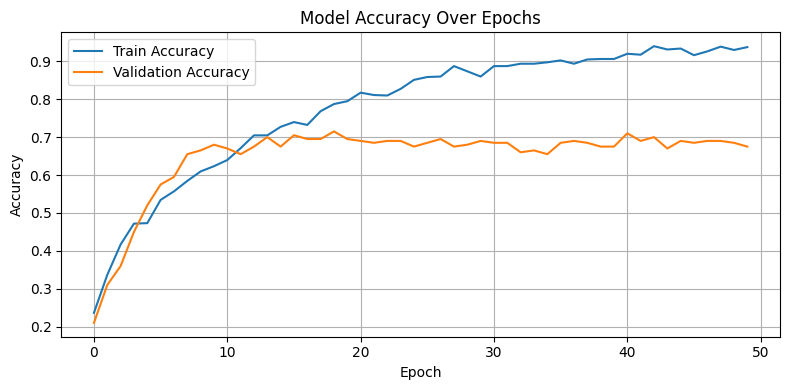

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step

🎵 Predicted Genre: jazz (Confidence: 1.00)

🔁 Top 5 Recommendations:
                                              filename      genre
803  /content/drive/MyDrive/GTZAN/genres_original/c...  classical
219  /content/drive/MyDrive/GTZAN/genres_original/j...       jazz
230  /content/drive/MyDrive/GTZAN/genres_original/j...       jazz
613  /content/drive/MyDrive/GTZAN/genres_original/r...       rock
238  /content/drive/MyDrive/GTZAN/genres_original/j...       jazz


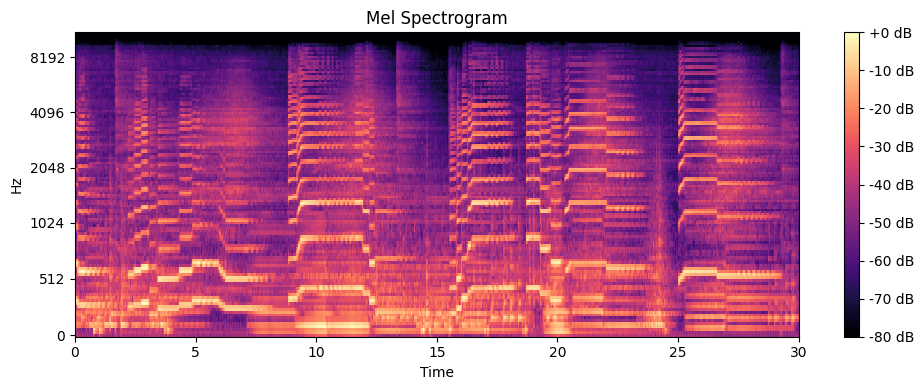

In [2]:
import os
import librosa
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import librosa.display
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics.pairwise import cosine_similarity
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv1D, MaxPooling1D, Flatten, BatchNormalization
from tensorflow.keras.utils import to_categorical

# 1. Feature Extraction Function
def extract_features(file_path, n_mfcc=60, duration=30, sr=22050):
    y, sr = librosa.load(file_path, duration=duration, sr=sr)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
    return np.mean(mfcc.T, axis=0)

# 2. Load Dataset
data_path = "/content/drive/MyDrive/GTZAN/genres_original"  # Update if needed
genres = os.listdir(data_path)

X, y, filenames = [], [], []
for genre in genres:
    genre_path = os.path.join(data_path, genre)
    for file in os.listdir(genre_path):
        try:
            path = os.path.join(genre_path, file)
            features = extract_features(path)
            X.append(features)
            y.append(genre)
            filenames.append(path)
        except:
            continue

X = np.array(X)
le = LabelEncoder()
y_encoded = to_categorical(le.fit_transform(y))
X_train, X_val, y_train, y_val = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# 3. CNN Model
model = Sequential([
    Conv1D(128, 3, activation='relu', input_shape=(X.shape[1], 1)),
    BatchNormalization(),
    MaxPooling1D(2),
    Dropout(0.3),

    Conv1D(128, 3, activation='relu'),
    BatchNormalization(),
    MaxPooling1D(2),
    Dropout(0.3),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.4),
    Dense(10, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# 4. Train the Model and Track History
X_train_cnn = X_train[..., np.newaxis]
X_val_cnn = X_val[..., np.newaxis]
history = model.fit(X_train_cnn, y_train, epochs=50, batch_size=32, validation_data=(X_val_cnn, y_val))

# 5. Evaluate Model on Validation Set
val_loss, val_accuracy = model.evaluate(X_val_cnn, y_val, verbose=0)
print(f"\n✅ Validation Accuracy: {val_accuracy * 100:.2f}%")

# 6. Plot Training and Validation Accuracy
plt.figure(figsize=(8, 4))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Model Accuracy Over Epochs')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 7. Store data for recommender
df_tracks = pd.DataFrame(X)
df_tracks['genre'] = y
df_tracks['filename'] = filenames

# 8. Predict Genre Function
def predict_genre(file_path):
    features = extract_features(file_path).reshape(1, -1, 1)
    preds = model.predict(features)
    genre = le.inverse_transform([np.argmax(preds)])
    confidence = np.max(preds)
    return genre[0], confidence

# 9. Recommender Function
def recommend_similar(file_path, top_k=5):
    input_features = extract_features(file_path).reshape(1, -1)
    similarities = cosine_similarity(input_features, df_tracks.iloc[:, :-2])
    top_indices = np.argsort(similarities[0])[::-1][1:top_k+1]
    return df_tracks.iloc[top_indices][['filename', 'genre']]

# 10. Spectrogram Viewer
def show_spectrogram(file_path):
    y, sr = librosa.load(file_path)
    S = librosa.feature.melspectrogram(y=y, sr=sr)
    S_DB = librosa.power_to_db(S, ref=np.max)
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(S_DB, sr=sr, x_axis='time', y_axis='mel')
    plt.colorbar(format='%+2.0f dB')
    plt.title('Mel Spectrogram')
    plt.tight_layout()
    plt.show()

# 11. Example Usage
file_path = "/content/drive/MyDrive/GTZAN/genres_original/jazz/jazz.00030.wav"  # Change as needed
genre, conf = predict_genre(file_path)
print(f"\n🎵 Predicted Genre: {genre} (Confidence: {conf:.2f})")

print("\n🔁 Top 5 Recommendations:")
print(recommend_similar(file_path))

show_spectrogram(file_path)
